In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.utils import prettify

from jaxley_mech.channels.chen24 import Phototransduction
from jaxley_mech.channels.lk04 import Leak


In [2]:
# primate cone
prefix = "Phototransduction"
params_primate_cone = {
    f"{prefix}_sigma": 22, # /s, opsin decay rate constant
    f"{prefix}_phi": 22, # /s, PDE decay rate constant
    f"{prefix}_eta": 2000, # /s, PDE dark activate rate
    f"{prefix}_gamma": 10, # unitless, Opsin gain
    f"{prefix}_beta": 9, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.5, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 35, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark   
    f"{prefix}_surface_area": 300, # um^2, upper bound 
}

# primate rod
params_primate_rod = {
    f"{prefix}_sigma": 7.07, # /s, opsin decay rate constant
    f"{prefix}_phi": 7.07, # /s, PDE decay rate constant
    f"{prefix}_eta": 2.53, # /s, PDE dark activate rate
    f"{prefix}_gamma": 4.2, # unitless, Opsin gain
    f"{prefix}_beta": 25, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.5, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 15.5, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark    
    f"{prefix}_surface_area": 300, # um^2, upper bound 
}

# mouse cone
params_mouse_cone = {
    f"{prefix}_sigma": 9.74, # /s, opsin decay rate constant
    f"{prefix}_phi": 9.74, # /s, PDE decay rate constant
    f"{prefix}_eta": 761, # /s, PDE dark activate rate
    f"{prefix}_gamma": 20, # unitless, Opsin gain
    f"{prefix}_beta": 2.64, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.4, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 20, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark  
    f"{prefix}_surface_area": 100, # um^2, upper bound 
 
}

# mouse rod
params_mouse_rod = {
    f"{prefix}_sigma": 7.66, # /s, opsin decay rate constant
    f"{prefix}_phi": 7.66, # /s, PDE decay rate constant
    f"{prefix}_eta": 1.62, # /s, PDE dark activate rate
    f"{prefix}_gamma": 8, # unitless, Opsin gain
    f"{prefix}_beta": 25, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.4, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 13.4, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark 
    f"{prefix}_surface_area": 200, # um^2, upper bound 
}


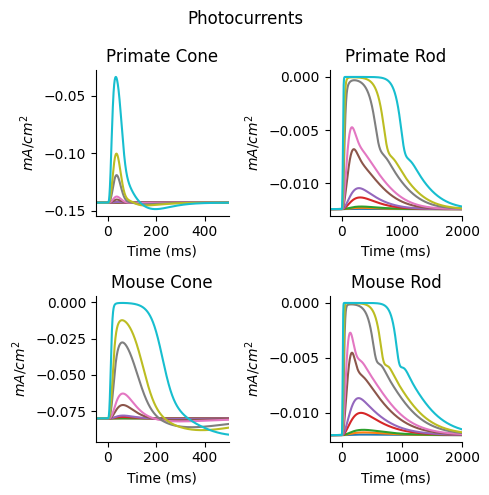

In [3]:
prefix = "Phototransduction"
to_records = ["iPhoto"]

background_intensities = [0]

names = ["Primate Cone", "Primate Rod", "Mouse Cone", "Mouse Rod", ]
mosaic = [["Primate Cone", "Primate Rod"], ["Mouse Cone", "Mouse Rod"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(5, 5))

for ii, params in enumerate([params_primate_cone, params_primate_rod, params_mouse_cone, params_mouse_rod]):

    for background_intensity in background_intensities:
        if background_intensity > 0:
            intensities = [0.02]
        else:
            intensities = [1, 5, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000]

        for intensity in intensities:
            pre_light_time = 1000  # ms
            light_on_time = 20  # ms
            total_time = pre_light_time + 2000 # ms
            dt = 0.025 # ms
            time_steps = int(total_time // dt + 1)

            cell = Compartment()
            cell.insert(Phototransduction(solver='newton'))
            cell.insert(Leak())

            for name, param in params.items():
                cell.set(name, param)

            cell.init_states()

            Jhv = jnp.zeros(time_steps) + background_intensity
            light_on_start = int(pre_light_time / dt)
            light_on_end = int((pre_light_time + light_on_time) / dt)

            Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)

            # Apply the light stimuli by "clamping" Jhv
            cell.clamp("Phototransduction_Stim", Jhv, verbose=False)

            for rec in to_records:
                cell.record(rec, verbose=False)

            # Run the simulation
            s = jx.integrate(cell, delta_t=dt, t_max=total_time)
            s = prettify(s, to_records, dt) 
            
            ax[names[ii]].plot((s["time"]-pre_light_time)[int(500/dt):], s["iPhoto"][int(500/dt):], label=f"{intensity} R*/s")
            ax[names[ii]].spines[['top', 'right']].set_visible(False)

            if "cone" in names[ii].lower():
                ax[names[ii]].set_xlim(-50, 500)
            else:
                ax[names[ii]].set_xlim(-200, 2000)                

            ax[names[ii]].set_xlabel("Time (ms)")
            ax[names[ii]].set_ylabel(r"$mA/cm^2$")
            ax[names[ii]].set_title(f"{names[ii]}")

    fig.suptitle(f"Photocurrents")
    fig.tight_layout()

In [4]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-10-23 20:35:49CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.2.1

jaxley    : 0.4.0
matplotlib: 3.9.2
jax       : 0.4.35

Watermark: 2.4.3

